In [2]:
import jax
import brainpy as bp
import brainpy.math as bm
import matplotlib.pyplot as plt

/Users/admin/miniconda3/envs/JVLabEnv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CANN2D：try to simulate Levy flight Simulation

In [ ]:
class CANN2D(bp.dyn.NeuDyn):
    def __init__(self, length, m = 0.1, tau=1., tau_v=10., k=8.1, a=0.5, A=10., J0=4.,
               z_min=-bm.pi, z_max=bm.pi, name=None):
        super(CANN2D, self).__init__(size=(length, length), name=name)

        # params
        self.length = length
        self.tau_v = tau_v  # time constant of SFA
        self.tau = tau  # The synaptic time constant
        self.k = k  # Degree of the rescaled inhibition
        self.a = a  # Half-width of the range of excitatory connections
        self.A = A  # Magnitude of the external input
        self.J0 = J0  # maximum connection value
        self.m = m

        # feature space
        self.z_min = z_min
        self.z_max = z_max
        self.z_range = z_max - z_min
        self.x = bm.linspace(z_min, z_max, length)  # The encoded feature values
        self.rho = length / self.z_range  # The neural density
        self.dx = self.z_range / length  # The stimulus density

        # The connections
        self.conn_mat = self.make_conn()

        # variables
        self.r = bm.Variable(bm.zeros((length, length)))
        self.u = bm.Variable(bm.zeros((length, length)))
        self.v = bm.Variable(bm.zeros((length, length)))
        self.input = bm.Variable(bm.zeros((length, length)))


    def show_conn(self):
        plt.imshow(bm.as_numpy(self.conn_mat))
        plt.colorbar()
        plt.show()
    
    def dist(self, d):
        v_size = bm.asarray([self.z_range, self.z_range])
        return bm.where(d > v_size / 2, v_size - d, d)

    def make_conn(self):
        x1, x2 = bm.meshgrid(self.x, self.x)
        value = bm.stack([x1.flatten(), x2.flatten()]).T

        @jax.vmap
        def get_J(v):
            d = self.dist(bm.abs(v - value))
            d = bm.linalg.norm(d, axis=1)
            #d = d.reshape((self.length, self.length))
            Jxx = self.J0 * bm.exp(-0.5 * bm.square(d / self.a)) / (bm.sqrt(2 * bm.pi) * self.a)
            return Jxx

        return get_J(value)

    def get_stimulus_by_pos(self, pos):
        assert bm.size(pos) == 2
        x1, x2 = bm.meshgrid(self.x, self.x)
        value = bm.stack([x1.flatten(), x2.flatten()]).T
        d = self.dist(bm.abs(bm.asarray(pos) - value))
        d = bm.linalg.norm(d, axis=1)
        d = d.reshape((self.length, self.length))
        return self.A * bm.exp(-0.25 * bm.square(d / self.a))

    def update(self):
        r1 = bm.square(self.u)
        r2 = 1.0 + self.k * bm.sum(r1)
        self.r.value = r1 / r2
        Irec = (self.r.flatten() @ self.conn_mat).reshape((self.length, self.length))
        self.u.value = self.u + (-self.u + self.input + Irec - self.v) / self.tau * bp.share['dt']
        self.v.value = self.v + (-self.v + self.m * self.u) / self.tau_v * bp.share['dt']
        self.input[:] = 0.

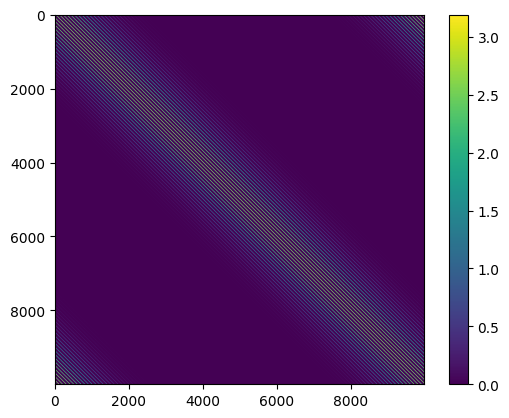

In [4]:
cann = CANN2D(length=100, k = 0.1)
cann.show_conn()

In [5]:
# encoding
Iext, length = bp.inputs.section_input(
    values=[cann.get_stimulus_by_pos([0., 0.]), 0.],
    durations=[10., 20.],
    return_length=True
)
runner = bp.DSRunner(cann,
                     inputs=['input', Iext, 'iter'],
                     monitors=['r'])
runner.run(length)

Predict 300 steps: : 100%|██████████| 300/300 [00:02<00:00, 144.34it/s]


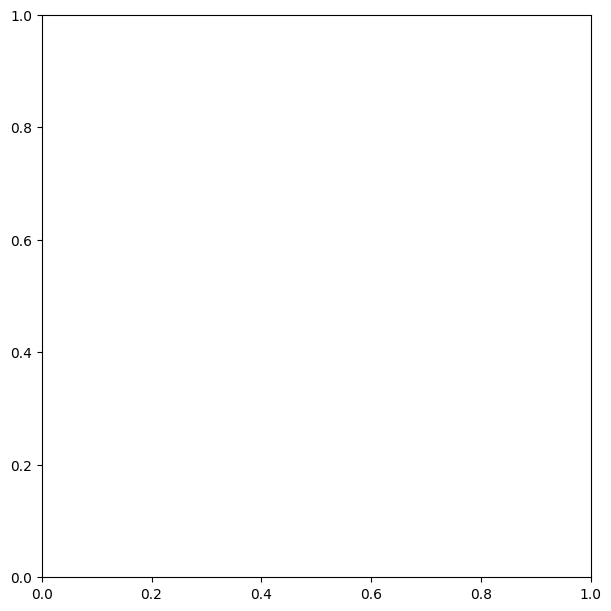

In [6]:
bp.visualize.animate_2D(values=runner.mon.r.reshape((-1, cann.num)),
                        net_size=(cann.length, cann.length))

In [13]:
# tracking
length = 20
positions = bp.inputs.ramp_input(-bm.pi, bm.pi, duration=length, t_start=0)
positions = bm.stack([positions, positions]).T
Iext = jax.vmap(cann.get_stimulus_by_pos)(positions)
runner = bp.DSRunner(cann,
                     inputs=['input', Iext, 'iter'],
                     monitors=['r'])
runner.run(length)

Predict 200 steps: : 100%|██████████| 200/200 [00:01<00:00, 128.63it/s]


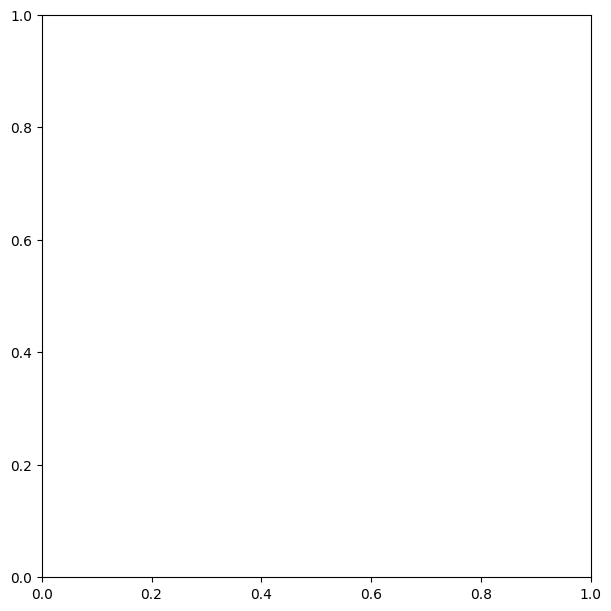

In [14]:
bp.visualize.animate_2D(values=runner.mon.r.reshape((-1, cann.num)),
                        net_size=(cann.length, cann.length))

In [15]:
import numpy as np

class TwoDCANN:
    def __init__(self, N, a, tau, tau_v, dt, T, ini_time, sample_time, J0, k, sigma_U, sigma_V, m):
        self.N = N
        self.a = a
        self.tau = tau
        self.tau_v = tau_v
        self.dt = dt
        self.T = T
        self.ini_time = ini_time
        self.sample_time = sample_time
        self.J0 = J0
        self.k = k
        self.sigma_U = sigma_U
        self.sigma_V = sigma_V
        self.m = m

        self.pos = np.linspace(-np.pi, np.pi, N + 1)[:N]

        self.J = np.zeros((N, N))
        for i in range(N):
            for j in range(N):
                dx = min(self.pos[i] - self.pos[0], np.pi - self.pos[i])
                dy = min(self.pos[j] - self.pos[0], np.pi - self.pos[j])
                self.J[i, j] = J0 / (2 * np.pi * a ** 2) * np.exp(-(dx ** 2 + dy ** 2) / (2 * a ** 2))

        self.Iext = np.zeros((N, N))
        self.U = np.zeros((N, N))
        self.V = np.zeros((N, N))
        self.r = np.zeros((N, N))

        lenth = int((T - sample_time) / dt)
        self.z = np.zeros((2, lenth))
        self.s = np.zeros((2, lenth))
        self.A_u = np.zeros(lenth)
        self.A_v = np.zeros(lenth)

    def expectation(self, U):
        xcenter = np.sum(U, axis=1)
        ycenter = np.sum(U, axis=0)
        x = np.linspace(-np.pi, np.pi, self.N)
        exppos = np.exp(1j * x)
        center = np.zeros(2)
        center[0] = np.angle(np.dot(exppos, xcenter))
        center[1] = np.angle(np.dot(exppos, ycenter))
        return center

    def fft2(self, x):
        return np.fft.fftshift(np.fft.fft2(x))

    def ifft2(self, x):
        return np.fft.ifft2(np.fft.ifftshift(x))

    def update(self):
        i = 0
        alpha = 1
        self.mon_U = np.zeros((self.N, self.N, 4000))

        for t in np.arange(self.dt, self.T - self.dt, self.dt):
            if t < self.ini_time:
                for x in range(self.N):
                    for y in range(self.N):
                        self.Iext[x, y] = alpha * np.exp(
                            -(self.pos[x] ** 2 + self.pos[y] ** 2) / (2 * self.a ** 2)
                        )
            else:
                self.Iext = np.zeros((self.N, self.N))

            dU = self.dt * (
                -self.U
                + self.ifft2(self.fft2(self.r) * self.fft2(self.J))
                - self.V
                + self.Iext
                + (self.sigma_U * np.sqrt(self.tau / self.dt))
                * np.random.normal(0, 1, (self.N, self.N))
            ) / self.tau

            self.U = self.U + dU
            dV = self.dt * (
                -self.V
                + self.m * self.U
                + (self.sigma_V * np.sqrt(self.tau_v / self.dt))
                * np.random.normal(0, 1, (self.N, self.N))
                * self.U
            ) / self.tau_v

            self.V = self.V + dV
            self.U = np.maximum(self.U, 0)
            self.r = self.U ** 2 / (1 + self.k * np.sum(self.U ** 2))

            if t >= self.sample_time:
                self.z[:, i] = self.expectation(self.U)
                self.s[:, i] = self.z[:, i] - self.expectation(self.V)
                self.s[:, i] = np.minimum(np.abs(self.s[:, i]), 2 * np.pi - np.abs(self.s[:, i]))
                self.A_u[i] = np.max(self.U)
                self.A_v[i] = np.max(self.V)
                i += 1

                if (i+1) % 50 == 0:
                    print((i+1)/50-1)
                    self.mon_U[:, :, int((i+1)/50-1)] = self.U


In [ ]:
# Params
N = 128
a = np.pi / 10
tau = 1
tau_v = 100
dt = tau / 10
T = 20050
ini_time = 30
sample_time = 50
J0 = 1
k = 0.05
sigma_U = 0.03
sigma_V = 0.15
m = (tau / tau_v) * 1

model2 = TwoDCANN(N, a, tau, tau_v, dt, T, ini_time, sample_time, J0, k, sigma_U, sigma_V, m)
model2.update()

/var/folders/f4/xn2m160x4j34ddfx9r4fnn040000gn/T/ipykernel_82697/3886285054.py:96: ComplexWarning: Casting complex values to real discards the imaginary part
  self.A_u[i] = np.max(self.U)
/var/folders/f4/xn2m160x4j34ddfx9r4fnn040000gn/T/ipykernel_82697/3886285054.py:97: ComplexWarning: Casting complex values to real discards the imaginary part
  self.A_v[i] = np.max(self.V)
/var/folders/f4/xn2m160x4j34ddfx9r4fnn040000gn/T/ipykernel_82697/3886285054.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  self.mon_U[:, :, int((i+1)/50-1)] = self.U


0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0
21.0
22.0
23.0
24.0
25.0
26.0
27.0
28.0
29.0
30.0
31.0
32.0
33.0
34.0
35.0
36.0
37.0
38.0
39.0
40.0
41.0
42.0
43.0
44.0
45.0
46.0
47.0
48.0
49.0
50.0
51.0
52.0
53.0
54.0
55.0
56.0
57.0
58.0
59.0
60.0
61.0
62.0
63.0
64.0
65.0
66.0
67.0
68.0
69.0
70.0
71.0
72.0
73.0
74.0
75.0
76.0
77.0
78.0
79.0
80.0
81.0
82.0
83.0
84.0
85.0
86.0
87.0
88.0
89.0
90.0
91.0
92.0
93.0
94.0
95.0
96.0
97.0
98.0
99.0
100.0
101.0
102.0
103.0
104.0
105.0
106.0
107.0
108.0
109.0
110.0
111.0
112.0
113.0
114.0
115.0
116.0
117.0
118.0
119.0
120.0
121.0
122.0
123.0
124.0
125.0
126.0
127.0
128.0
129.0
130.0
131.0
132.0
133.0
134.0
135.0
136.0
137.0
138.0
139.0
140.0
141.0
142.0
143.0
144.0
145.0
146.0
147.0
148.0
149.0
150.0
151.0
152.0
153.0
154.0
155.0
156.0
157.0
158.0
159.0
160.0
161.0
162.0
163.0
164.0
165.0
166.0
167.0
168.0
169.0
170.0
171.0
172.0
173.0
174.0
175.0
176.0
177.0
178.0
179.0
180.0
181.0
182.0
183.0
184.0


In [ ]:
# Params
N = 128
a = np.pi / 10
tau = 1
tau_v = 100
dt = tau / 10
T = 20050
ini_time = 30
sample_time = 50
J0 = 1
k = 0.05
sigma_U = 0.03
sigma_V = 0.0
m = (tau / tau_v) * 1

model3 = TwoDCANN(N, a, tau, tau_v, dt, T, ini_time, sample_time, J0, k, sigma_U, sigma_V, m)
model3.update()

/var/folders/f4/xn2m160x4j34ddfx9r4fnn040000gn/T/ipykernel_82697/3886285054.py:96: ComplexWarning: Casting complex values to real discards the imaginary part
  self.A_u[i] = np.max(self.U)
/var/folders/f4/xn2m160x4j34ddfx9r4fnn040000gn/T/ipykernel_82697/3886285054.py:97: ComplexWarning: Casting complex values to real discards the imaginary part
  self.A_v[i] = np.max(self.V)
/var/folders/f4/xn2m160x4j34ddfx9r4fnn040000gn/T/ipykernel_82697/3886285054.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  self.mon_U[:, :, int((i+1)/50-1)] = self.U


0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0
21.0
22.0
23.0
24.0
25.0
26.0
27.0
28.0
29.0
30.0
31.0
32.0
33.0
34.0
35.0
36.0
37.0
38.0
39.0
40.0
41.0
42.0
43.0
44.0
45.0
46.0
47.0
48.0
49.0
50.0
51.0
52.0
53.0
54.0
55.0
56.0
57.0
58.0
59.0
60.0
61.0
62.0
63.0
64.0
65.0
66.0
67.0
68.0
69.0
70.0
71.0
72.0
73.0
74.0
75.0
76.0
77.0
78.0
79.0
80.0
81.0
82.0
83.0
84.0
85.0
86.0
87.0
88.0
89.0
90.0
91.0
92.0
93.0
94.0
95.0
96.0
97.0
98.0
99.0
100.0
101.0
102.0
103.0
104.0
105.0
106.0
107.0
108.0
109.0
110.0
111.0
112.0
113.0
114.0
115.0
116.0
117.0
118.0
119.0
120.0
121.0
122.0
123.0
124.0
125.0
126.0
127.0
128.0
129.0
130.0
131.0
132.0
133.0
134.0
135.0
136.0
137.0
138.0
139.0
140.0
141.0
142.0
143.0
144.0
145.0
146.0
147.0
148.0
149.0
150.0
151.0
152.0
153.0
154.0
155.0
156.0
157.0
158.0
159.0
160.0
161.0
162.0
163.0
164.0
165.0
166.0
167.0
168.0
169.0
170.0
171.0
172.0
173.0
174.0
175.0
176.0
177.0
178.0
179.0
180.0
181.0
182.0
183.0
184.0


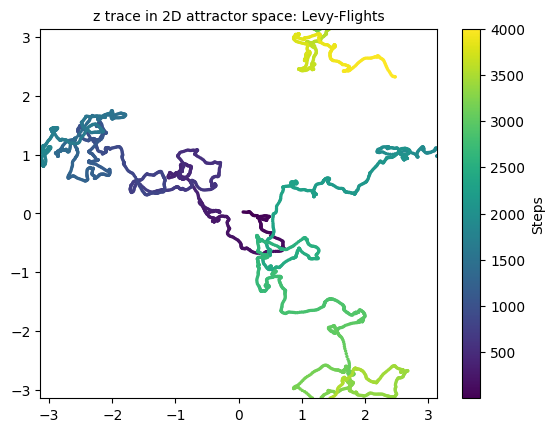

In [ ]:
# Visualization
stepsize = 50
zz = model2.z[:, :stepsize*(len(model2.z[0,:])//stepsize)]
plot_z = zz[:, ::stepsize]
c = np.linspace(1, len(plot_z[0,:]), len(plot_z[0,:]))
scatter = plt.scatter(plot_z[0, :], plot_z[1, :], 2, c)

cbar = plt.colorbar(scatter)
cbar.set_label('Steps')  

plt.box(True) 
plt.axis([-np.pi, np.pi, -np.pi, np.pi])
plt.title('z trace in 2D attractor space: Levy-Flights', fontsize=10)
plt.show()



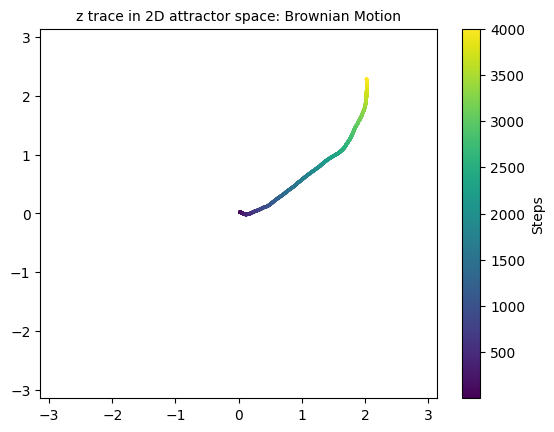

In [ ]:
# Visualization
stepsize = 50
zz = model3.z[:, :stepsize*(len(model2.z[0,:])//stepsize)]
plot_z = zz[:, ::stepsize]
c = np.linspace(1, len(plot_z[0,:]), len(plot_z[0,:]))
scatter = plt.scatter(plot_z[0, :], plot_z[1, :], 2, c)

cbar = plt.colorbar(scatter)
cbar.set_label('Steps')  

plt.box(True) 
plt.axis([-np.pi, np.pi, -np.pi, np.pi])
plt.title('z trace in 2D attractor space: Brownian Motion', fontsize=10)
plt.show()

In [ ]:
# Params
N = 128
a = np.pi / 10
tau = 1
tau_v = 100
dt = tau / 10
T = 20050
ini_time = 30
sample_time = 50
J0 = 1
k = 0.05
sigma_U = 0.03
sigma_V = 0.15
m = (tau / tau_v) * 1

model4 = TwoDCANN(N, a, tau, tau_v, dt, T, ini_time, sample_time, J0, k, sigma_U, sigma_V, m)
model4.update()

/var/folders/f4/xn2m160x4j34ddfx9r4fnn040000gn/T/ipykernel_82697/3886285054.py:96: ComplexWarning: Casting complex values to real discards the imaginary part
  self.A_u[i] = np.max(self.U)
/var/folders/f4/xn2m160x4j34ddfx9r4fnn040000gn/T/ipykernel_82697/3886285054.py:97: ComplexWarning: Casting complex values to real discards the imaginary part
  self.A_v[i] = np.max(self.V)
/var/folders/f4/xn2m160x4j34ddfx9r4fnn040000gn/T/ipykernel_82697/3886285054.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  self.mon_U[:, :, int((i+1)/50-1)] = self.U


0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0
21.0
22.0
23.0
24.0
25.0
26.0
27.0
28.0
29.0
30.0
31.0
32.0
33.0
34.0
35.0
36.0
37.0
38.0
39.0
40.0
41.0
42.0
43.0
44.0
45.0
46.0
47.0
48.0
49.0
50.0
51.0
52.0
53.0
54.0
55.0
56.0
57.0
58.0
59.0
60.0
61.0
62.0
63.0
64.0
65.0
66.0
67.0
68.0
69.0
70.0
71.0
72.0
73.0
74.0
75.0
76.0
77.0
78.0
79.0
80.0
81.0
82.0
83.0
84.0
85.0
86.0
87.0
88.0
89.0
90.0
91.0
92.0
93.0
94.0
95.0
96.0
97.0
98.0
99.0
100.0
101.0
102.0
103.0
104.0
105.0
106.0
107.0
108.0
109.0
110.0
111.0
112.0
113.0
114.0
115.0
116.0
117.0
118.0
119.0
120.0
121.0
122.0
123.0
124.0
125.0
126.0
127.0
128.0
129.0
130.0
131.0
132.0
133.0
134.0
135.0
136.0
137.0
138.0
139.0
140.0
141.0
142.0
143.0
144.0
145.0
146.0
147.0
148.0
149.0
150.0
151.0
152.0
153.0
154.0
155.0
156.0
157.0
158.0
159.0
160.0
161.0
162.0
163.0
164.0
165.0
166.0
167.0
168.0
169.0
170.0
171.0
172.0
173.0
174.0
175.0
176.0
177.0
178.0
179.0
180.0
181.0
182.0
183.0
184.0


/Users/admin/miniconda3/envs/JVLabEnv/lib/python3.11/site-packages/matplotlib/animation.py:908: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


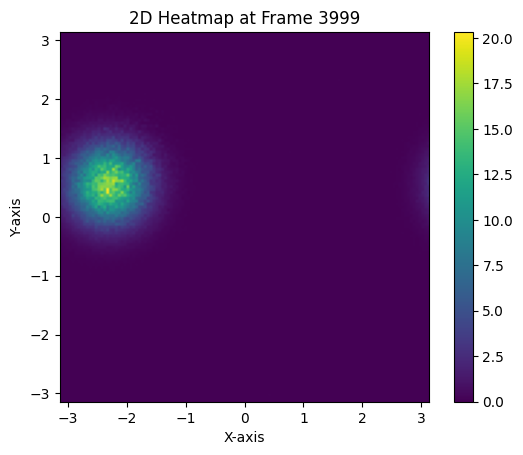

In [ ]:
from matplotlib.animation import FuncAnimation

# Function to update the plot for each frame
def update(frame):
    plt.clf()  # Clear the previous frame
    heatmap_data = model4.mon_U[:, :, frame]
    plt.imshow(heatmap_data, cmap='viridis', extent=[-np.pi, np.pi, -np.pi, np.pi])
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title(f'2D Heatmap at Frame {frame}')
    plt.colorbar()

# Create the animation
animation = FuncAnimation(plt.gcf(), update, frames=model4.mon_U.shape[2], interval=100, repeat=False)
animation.save('/Users/Shared/win_f/project/PK_Neuro/2d_U_animation.gif', writer='pillow')
plt.show()


